Importing Modules for keras, matplot and cv2

In [1]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K
import numpy as np
from PIL import Image
import h5py
from matplotlib import pyplot as plt
import cv2

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet')

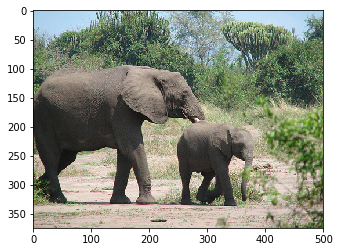

In [3]:
img_path = '/Users/gopal/projects/learning/deeplearningsamples/mama---baby-elephant_5765.jpg'
img = Image.open(img_path)
plt.imshow(img)

In [4]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [5]:
preds = model.predict(x)
print('Predicted : ', decode_predictions(preds, top=3)[0])


('Predicted : ', [(u'n02504458', u'African_elephant', 0.85371286), (u'n01871265', u'tusker', 0.10780991), (u'n02504013', u'Indian_elephant', 0.038477264)])


Setting up the grad-CAM algorithm (class activation maps). We find the index of the class with the max on predictions (which is the predicted class). We use that to get the model output from that class. We get the feature map of the last convolutional layer in VGG16. We can now compute the gradient of the model_output for the specific class with respect to the ourput feature map of that last convolutional layer. pooled_grads gets us the mean intensity of the gradients over a specific feature map channel. iterate allows you to access the values that you just defined. We can get then the values of the two numpy arrays we defines, mean_grad_values and convolutional layer outputs for our image.

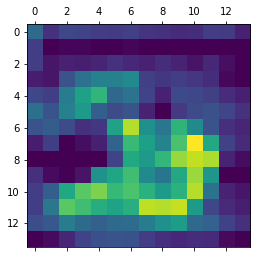

In [6]:
index = np.argmax(preds[0])
model_output = model.output[:, index]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for n in range(512):
    conv_layer_output_value[:,:, n] *= pooled_grads_value[n]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Using opencv and converting heatmap to RGB and mixing 

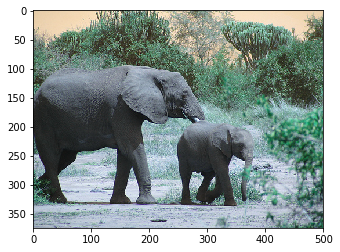

In [7]:
img = cv2.imread(img_path)
plt.imshow(img)

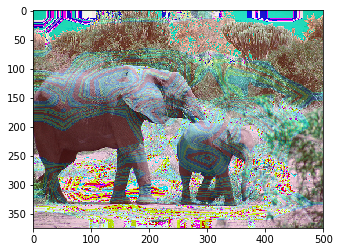

In [24]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.uint8((0.2*heatmap) + img)
plt.imshow(superimposed_img)